### 测试

In [ ]:
from utils.dataset_utils import get_distribution, remove_class
from instance_selection.parameter.parameter import *  # 导入参数的设定
from instance_selection.operator.init_toolbox import init_toolbox_emosaic
from instance_selection.operator.metrics import calculate_gmean_mauc, calculate_average_gmean_mauc
from instance_selection.operator.genetic_operator import selTournamentNDCD
from instance_selection.operator.ensemble import vote_result_ensembles, ensemble_individuals
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import scipy.io as sio  # 从.mat文件中读取数据集
import random
from deap import tools
import warnings

warnings.filterwarnings("ignore")  # 忽略警告

datasetname = 'RELATHE.mat'
mat_data = sio.loadmat('../datasets/mat/raw_data/' + datasetname)

x = mat_data['X']
y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
#x,y=remove_class(x,y,2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)  # 划分数据集
scaler = StandardScaler()  # 数据的标准化
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
unique_elements_all, classes_all, counts_all = get_distribution(y)  # 获取原始数据集分布
unique_elements_train, classes_train, counts_train = get_distribution(y_train)  # 获取训练集分布
unique_elements_test, classes_test, counts_test = get_distribution(y_test)  # 获取测试集分布
print(datasetname + f' distribution: {counts_all}')
print(f'trainset distribution: {counts_train}')
print(f'testset distribution: {counts_test}')

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
from scipy.io import savemat

# 保存为 .mat 文件
data_dict = {'X': x, 'Y': y.reshape(-1, 1)}  # 以字典形式存储
savemat(datasetname, data_dict)
# # 输出保存成功
# print("数据保存成功！")

In [ ]:
import numpy as np


def ensure_min_samples(X, Y, ind, min_samples=5):
    """
    确保ind中选择的实例，每个类别至少有min_samples个，
    若不足，则从未选择的实例中补充。
    
    :param X: 实例数据，形状为 (n_samples, n_features)
    :param Y: 标签数据，形状为 (n_samples,)
    :param ind: 选择序列，形状为 (n_samples,)
    :param min_samples: 每个类别的最小选择样本数
    :return: 更新后的选择序列 ind
    """
    ind = np.array(ind)
    Y = np.array(Y)

    unique_classes = np.unique(Y)

    for cls in unique_classes:
        selected_indices = np.where((ind == 1) & (Y == cls))[0]
        unselected_indices = np.where((ind == 0) & (Y == cls))[0]

        if len(selected_indices) < min_samples:
            num_needed = min_samples - len(selected_indices)
            if len(unselected_indices) >= num_needed:
                additional_indices = np.random.choice(unselected_indices, num_needed, replace=False)
            else:
                additional_indices = unselected_indices  # 如果不足，则全选

            ind[additional_indices] = 1

    return ind


# 示例数据
X = np.random.rand(20, 5)  # 20个实例，每个实例5个特征
Y = np.random.randint(0, 4, 20)  # 20个实例的标签，类别为 0,1,2,3
ind = np.random.choice([0, 1], size=20, p=[0.7, 0.3])  # 随机选择部分实例

updated_ind = ensure_min_samples(X, Y, ind, min_samples=5)
print("更新后的选择序列:", updated_ind)


In [ ]:
import pandas as pd

# 数据
gmean_data = [
    [0.867204, 0.706186, 0.90059, 0.895197, 0.886062, 0.90059],
    [0.867204, 0.821475, 0.886062, 0.90059, 0.914664, 0.90059],
    [0.867204, 0.734127, 0.886062, 0.886062, 0.914664, 0.886062],
    [0.867204, 0.638961, 0.886062, 0.914664, 0.895197, 0.867204],
    [0.867204, 0.798275, 0.886062, 0.867204, 0.895197, 0.852503],
    [0.867204, 0.593159, 0.886062, 0.90059, 0.914664, 0.881423],
    [0.867204, 0.697358, 0.886062, 0.0, 0.895197, 0.871041],
    [0.867204, 0.633592, 0.886062, 0.871041, 0.895197, 0.90059],
    [0.867204, 0.786738, 0.886062, 0.881423, 0.881423, 0.895197],
    [0.867204, 0.740789, 0.90059, 0.881423, 0.90059, 0.0],
    [0.867204, 0.755039, 0.886062, 0.881423, 0.933336, 0.0],
    [0.867204, 0.703268, 0.0, 0.881423, 0.881423, 0.886062],
    [0.867204, 0.847488, 0.886062, 0.895197, 0.914664, 0.881423],
    [0.867204, 0.703268, 0.0, 0.881423, 0.881423, 0.886062],
    [0.867204, 0.734127, 0.886062, 0.881423, 0.895197, 0.871041],
    [0.867204, 0.743421, 0.886062, 0.881423, 0.914664, 0.90059],
    [0.867204, 0.0, 0.90059, 0.881423, 0.895197, 0.867204],
    [0.867204, 0.0, 0.886062, 0.90059, 0.895197, 0.914664],
    [0.867204, 0.837276, 0.886062, 0.895197, 0.914664, 0.881423],
    [0.867204, 0.725969, 0.886062, 0.881423, 0.90059, 0.867204],
    [0.867204, 0.0, 0.886062, 0.90059, 0.914664, 0.895197]
]

mauc_data = [
    [0.953261, 0.919928, 0.965217, 0.950362, 0.957609, 0.942754],
    [0.953261, 0.908696, 0.943116, 0.947101, 0.967029, 0.94529],
    [0.953261, 0.868478, 0.952174, 0.947826, 0.963406, 0.941304],
    [0.953261, 0.766667, 0.961957, 0.940217, 0.95471, 0.933333],
    [0.953261, 0.919565, 0.923188, 0.91558, 0.967029, 0.938768],
    [0.953261, 0.747464, 0.944203, 0.931159, 0.956522, 0.946377],
    [0.953261, 0.855072, 0.955435, 0.92971, 0.969928, 0.940217],
    [0.953261, 0.869565, 0.956522, 0.944928, 0.969928, 0.92971],
    [0.953261, 0.906884, 0.937681, 0.950362, 0.952536, 0.955435],
    [0.953261, 0.876812, 0.965217, 0.961957, 0.968116, 0.947826],
    [0.953261, 0.924275, 0.951087, 0.929348, 0.957609, 0.951449],
    [0.953261, 0.806159, 0.903623, 0.955072, 0.965942, 0.948913],
    [0.953261, 0.943116, 0.956884, 0.952536, 0.977536, 0.953986],
    [0.953261, 0.806159, 0.903623, 0.955072, 0.965942, 0.948913],
    [0.953261, 0.922826, 0.962681, 0.928261, 0.967754, 0.922826],
    [0.953261, 0.872101, 0.949275, 0.946377, 0.949275, 0.927174],
    [0.953261, 0.658696, 0.968841, 0.960507, 0.963406, 0.94058],
    [0.953261, 0.832971, 0.96413, 0.948551, 0.963768, 0.955435],
    [0.953261, 0.942754, 0.953623, 0.955435, 0.961957, 0.950725],
    [0.953261, 0.91558, 0.936232, 0.951087, 0.939493, 0.943841],
    [0.953261, 0.83442, 0.92971, 0.930072, 0.958333, 0.942029]
]

# 创建DataFrame
gmean_df = pd.DataFrame(gmean_data, columns=[f"Gmean_{i + 1}" for i in range(6)])
gmean_df.insert(0, "Run", [f"第{i + 1}次运行" for i in range(len(gmean_data))])

mauc_df = pd.DataFrame(mauc_data, columns=[f"mAUC_{i + 1}" for i in range(6)])
mauc_df.insert(0, "Run", [f"第{i + 1}次运行" for i in range(len(mauc_data))])

# 保存到Excel文件
output_path = "Gmean_MAUC.xlsx"
with pd.ExcelWriter(output_path) as writer:
    gmean_df.to_excel(writer, sheet_name="Gmean", index=False)
    mauc_df.to_excel(writer, sheet_name="MAUC", index=False)

output_path


In [ ]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
for i in range(len(a)):
    a[i] = a[i] + 1
print(a)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# 1. 数据准备和转换
data_dict = {
    'Balance_Scale': {
        'MILE': [5, 9, 13, 19, 20, 29, 42, 33, 36, 39, 34, 34, 35, 41, 38, 40, 41, 40, 40, 42, 42, 41, 39, 40, 40, 41,
                 36, 38, 37, 41, 42, 38, 43, 45, 46, 39, 42, 41, 40, 39, 40],
        'MILE-NC': [3, 5, 7, 9, 11, 12, 16, 17, 18, 20, 23, 26, 24, 26, 26, 27, 29, 30, 30, 34, 33, 32, 35, 29, 33, 32,
                    36, 37, 34, 31, 39, 37, 37, 32, 38, 37, 39, 40, 35, 38, 39]
    },
    'Nursery': {
        'MILE': [7, 11, 16, 24, 30, 41, 40, 48, 44, 43, 40, 41, 38, 42, 39, 40, 42, 44, 37, 37, 39, 46, 43, 43, 48, 43,
                 46, 40, 42, 43, 41, 44, 44, 47, 47, 45, 45, 43, 43, 40, 40],
        'MILE-NC': [9, 14, 17, 25, 33, 28, 31, 27, 31, 32, 34, 29, 34, 28, 29, 34, 32, 30, 31, 24, 30, 29, 26, 28, 23,
                    28, 26, 24, 25, 23, 30, 32, 28, 33, 33, 35, 31, 28, 27, 27, 34]
    },
    'Car': {
        'MILE': [4, 7, 11, 13, 17, 20, 27, 34, 34, 37, 37, 35, 40, 36, 40, 38, 41, 40, 42, 43, 38, 44, 40, 40, 41, 41,
                 43, 45, 38, 41, 37, 41, 37, 40, 40, 38, 39, 42, 43, 42, 43],
        'MILE-NC': [3, 4, 6, 10, 14, 18, 17, 20, 20, 20, 22, 24, 25, 25, 24, 23, 26, 25, 27, 25, 28, 27, 29, 26, 26, 27,
                    30, 27, 33, 29, 27, 25, 25, 28, 28, 24, 28, 26, 29, 30, 27]
    }
}

# 转换为比例并创建DataFrame
dfs = []
for dataset in data_dict:
    for algorithm in data_dict[dataset]:
        # 只取前30个数据点(0-29代)
        values = np.array(data_dict[dataset][algorithm][:30]) / 60
        df_temp = pd.DataFrame({
            'Generation': np.arange(0, 30),
            'Proportion': values,
            'Algorithm': algorithm,
            'Dataset': dataset
        })
        dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

# 2. 设置绘图风格
plt.style.use('seaborn')
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 12
sns.set_style("whitegrid", {'grid.linestyle': ':', 'grid.linewidth': 0.5})

# 3. 创建图形
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# 颜色方案
palette = {'MILE': '#1f77b4', 'MILE-NC': '#ff7f0e'}

# 为每个数据集绘制子图
for i, dataset in enumerate(['Balance_Scale', 'Nursery', 'Car']):
    ax = axes[i]
    dataset_df = df[df['Dataset'] == dataset]

    # 绘制点线图
    sns.lineplot(
        data=dataset_df,
        x='Generation',
        y='Proportion',
        hue='Algorithm',
        style='Algorithm',
        markers=True,
        dashes=False,
        markersize=6,
        palette=palette,
        ax=ax
    )

    # 设置标题和坐标轴
    ax.set_title(dataset, fontweight='bold')
    ax.set_xlabel('Generation', fontweight='bold')
    if i == 0:
        ax.set_ylabel('Proportion of Feasible Solutions', fontweight='bold')
    else:
        ax.set_ylabel('')

    # 设置坐标轴范围
    ax.set_xlim(0, 29)
    ax.set_ylim(0, 1)

    # 设置刻度
    ax.set_xticks(np.arange(0, 31, 3))
    ax.set_yticks(np.arange(0, 1.1, 0.2))

    # 设置图例
    if i == 2:
        ax.legend(title='Algorithm', frameon=True, edgecolor='black')
    else:
        ax.get_legend().remove()

    # 设置网格
    ax.grid(True, linestyle=':', linewidth=0.5)

    # 设置边框
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

# 调整布局
plt.tight_layout()

# 4. 保存为高质量PDF
plt.savefig('algorithm_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

### 绘制可行解的比例

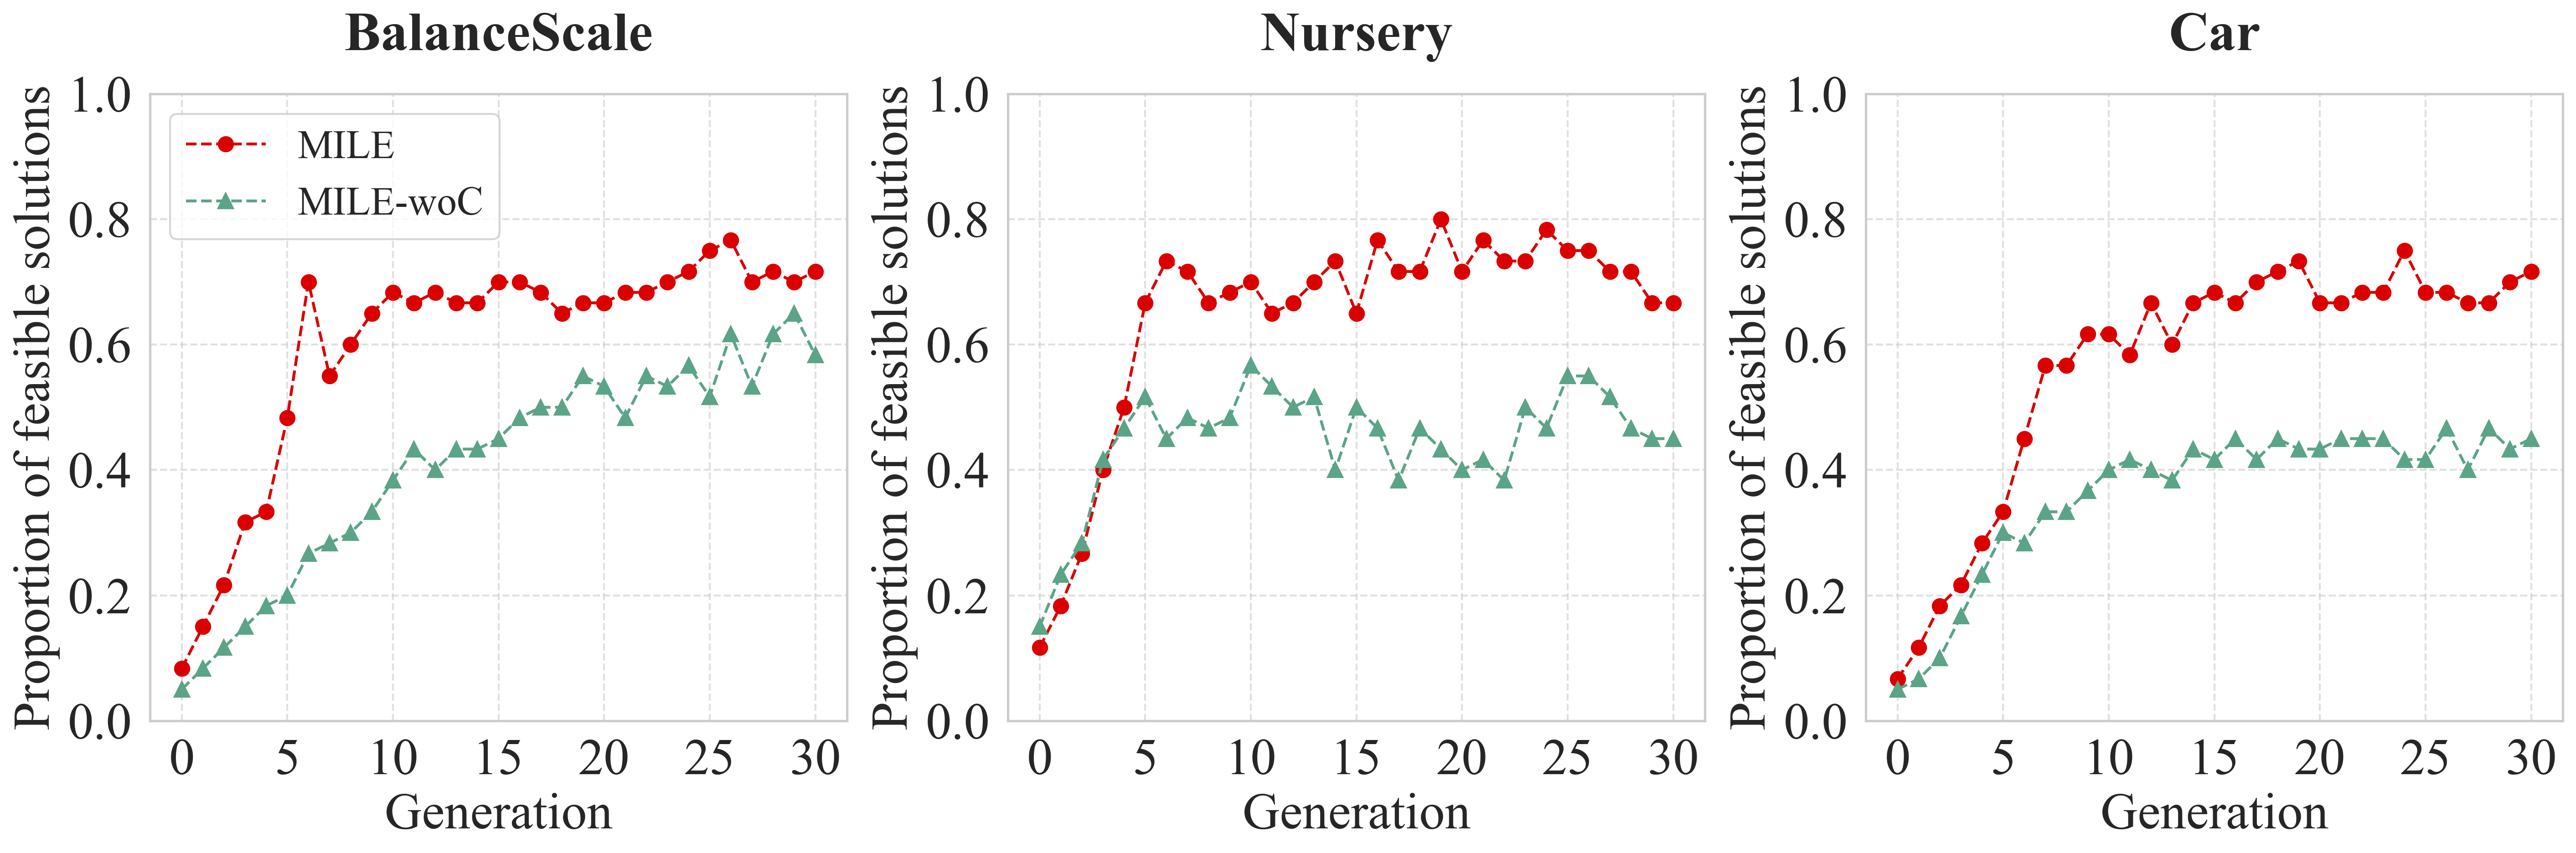

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 定义数据
# balance_scale_mile = [5, 9, 13, 19, 20, 29, 42, 33, 36, 39, 34, 34, 35, 41, 38, 40, 41, 40, 40, 42, 42, 41, 39, 40, 40, 41, 36, 38, 37, 41, 42, 38, 43, 45, 46, 39, 42, 41, 40, 39, 40]
balance_scale_mile = [5, 9, 13, 19, 20, 29, 42, 33, 36, 39, 41, 40, 41, 40, 40, 42, 42, 41, 39, 40, 40, 41, 41, 42, 43,
                      45, 46, 42, 43, 42, 43]
# balance_scale_mile_nc = [3, 5, 7, 9, 11, 12, 16, 17, 18, 20, 23, 26, 24, 26, 26, 27, 29, 30, 30, 34, 33, 32, 35, 29, 33, 32, 36, 37, 34, 31, 39, 37, 37, 32, 38, 37, 39, 40, 35, 38, 39]
balance_scale_mile_nc = [3, 5, 7, 9, 11, 12, 16, 17, 18, 20, 23, 26, 24, 26, 26, 27, 29, 30, 30, 33, 32, 29, 33, 32, 34,
                         31, 37, 32, 37, 39, 35]

# nursery_mile = [7, 11, 16, 24, 30, 41, 40, 48, 44, 43, 40, 41, 38, 42, 39, 40, 42, 44, 37, 37, 39, 46, 43, 43, 48, 43, 46, 40, 42, 43, 41, 44, 44, 47, 47, 45, 45, 43, 43, 40, 40]
nursery_mile = [7, 11, 16, 24, 30, 40, 44, 43, 40, 41, 42, 39, 40, 42, 44, 39, 46, 43, 43, 48, 43, 46, 44, 44, 47, 45,
                45, 43, 43, 40, 40]
# nursery_mile_nc = [9, 14, 17, 25, 33, 28, 31, 27, 31, 32, 34, 29, 34, 28, 29, 34, 32, 30, 31, 24, 30, 29, 26, 28, 23, 28, 26, 24, 25, 23, 30, 32, 28, 33, 33, 35, 31, 28, 27, 27, 34]

nursery_mile_nc = [9, 14, 17, 25, 28, 31, 27, 29, 28, 29, 34, 32, 30, 31, 24, 30, 28, 23, 28, 26, 24, 25, 23, 30, 28,
                   33, 33, 31, 28, 27, 27]

# car_mile = [4, 7, 11, 13, 17, 20, 27, 34, 34, 37, 37, 35, 40, 36, 40, 38, 41, 40, 42, 43, 38, 44, 40, 40, 41, 41, 43, 45, 38, 41, 37, 41, 37, 40, 40, 38, 39, 42, 43, 42, 43]
car_mile = [4, 7, 11, 13, 17, 20, 27, 34, 34, 37, 37, 35, 40, 36, 40, 41, 40, 42, 43, 44, 40, 40, 41, 41, 45, 41, 41,
            40, 40, 42, 43]
# car_mile_nc = [3, 4, 6, 10, 14, 18, 17, 20, 20, 20, 22, 24, 25, 25, 24, 23, 26, 25, 27, 25, 28, 27, 29, 26, 26, 27, 30, 27, 33, 29, 27, 25, 25, 28, 28, 24, 28, 26, 29, 30, 27]
car_mile_nc = [3, 4, 6, 10, 14, 18, 17, 20, 20, 22, 24, 25, 24, 23, 26, 25, 27, 25, 27, 26, 26, 27, 27, 27, 25, 25, 28,
               24, 28, 26, 27]

# 将数据合并成 DataFrame
df_balance_scale = pd.DataFrame({
    'MILE': balance_scale_mile,
    'MILE-NC': balance_scale_mile_nc
})
df_balance_scale['Dataset'] = 'Balance_Scale'

df_nursery = pd.DataFrame({
    'MILE': nursery_mile,
    'MILE-NC': nursery_mile_nc
})
df_nursery['Dataset'] = 'Nursery'

df_car = pd.DataFrame({
    'MILE': car_mile,
    'MILE-NC': car_mile_nc
})
df_car['Dataset'] = 'Car'

# 合并所有数据
df = pd.concat([df_balance_scale, df_nursery, df_car], ignore_index=True)

# 查看结果
df.head()

# 重新计算除以60后的数据
balance_scale_mile = [x / 60 for x in balance_scale_mile]
balance_scale_mile_nc = [x / 60 for x in balance_scale_mile_nc]

nursery_mile = [x / 60 for x in nursery_mile]
nursery_mile_nc = [x / 60 for x in nursery_mile_nc]

car_mile = [x / 60 for x in car_mile]
car_mile_nc = [x / 60 for x in car_mile_nc]

# 设置绘图风格
sns.set(style="whitegrid", font="Times New Roman")

# 创建一个包含3张子图的画布
fig, axes = plt.subplots(1, 3, figsize=(19, 6.4), dpi=300)

# 设置x轴和y轴的刻度范围
x_ticks = list(range(0, 31, 5))
y_ticks = [i / 5 for i in range(6)]

# 绘制每个子图
datasets = ['BalanceScale', 'Nursery', 'Car']
data_sets = [
    (balance_scale_mile, balance_scale_mile_nc),
    (nursery_mile, nursery_mile_nc),
    (car_mile, car_mile_nc)
]

for i, (mile, mile_nc) in enumerate(data_sets):
    ax = axes[i]

    # 绘制两条线
    ax.plot(range(len(mile)), mile, linestyle='--', marker='o',markersize=7.5, label='MILE', color='#DA0000')
    ax.plot(range(len(mile_nc)), mile_nc, linestyle='--', marker='^', markersize=7.5,label='MILE-woC', color='#5CA487')
    # 绘制两条线，设置点的大小
    
    # 设置x轴和y轴
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, fontsize=27)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{i / 5:.1f}' for i in range(6)], fontsize=27)

    ax.set_title(datasets[i], fontsize=29, fontweight='bold',pad=23)
    ax.set_xlabel('Generation', fontsize=27)
    ax.set_ylabel('Proportion of feasible solutions', fontsize=27)

    # 启用网格
    ax.grid(True, linestyle='--', alpha=0.6, which='both')

    # 设置图例
    if i == 0:
        ax.legend(fontsize=21, loc='upper left')

# 调整布局并保存为PDF
#plt.tight_layout(pad=2.0, w_pad=1.5, h_pad=1.2)
plt.tight_layout()
plt.savefig('Constrained and Unconstrained.pdf', format='pdf', dpi=300)

plt.show()
